# Point 3

In [1]:
import torch
import torchvision
from tqdm import trange
import cv2
import copy
from torchvision import transforms
from torchvision.models import alexnet
from torch.utils.data import random_split, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

device = torch.device("cpu")

print(device)

cpu


In [2]:
!rm best_model.pt

rm: cannot remove 'alex_orig.pt': No such file or directory


In [3]:
mean = [0.5224, 0.5224, 0.5224]
std = [0.2456, 0.2456, 0.2456]

train_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.PILToTensor(),
    transforms.Normalize(mean = mean, std = std),
    transforms.Lambda(lambda x: x.float())
    
])

test_transform = transforms.Compose([
    # you can add other transformations in this list
    # transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.PILToTensor(),
    transforms.Normalize(mean = mean, std = std),
    transforms.Lambda(lambda x: x.float())
])

In [4]:
image_open = lambda path: Image.open(path).convert("RGB")

BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=image_open)

trainset_classes = trainset.classes.copy()

subset_size = int(0.15*len(trainset))

validset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=image_open)

indices = torch.randperm(len(trainset))

valid_indices = indices[:subset_size]
train_indices = indices[subset_size:]

trainset = Subset(trainset, train_indices)
validset = Subset(validset, valid_indices)

# Apply transformations only to the training set
trainset.dataset.transform = train_transform
# Apply transformations to the validation set
validset.dataset.transform = test_transform

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=test_transform, loader=image_open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(trainset)},  splitted validset: {len(validset)}')

entire train folder: 1275, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


In [5]:
alex_net = alexnet(weights='DEFAULT')

In [6]:
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
alex_net.classifier[6] = torch.nn.Linear(in_features=4096, out_features=15)

alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
for param in alex_net.parameters():
    param.requires_grad = False

for param in alex_net.classifier[6].parameters():
    param.requires_grad = True

In [9]:
for name, param in alex_net.named_parameters():
    print(f'param name: {name} grad: {param.requires_grad}')

param name: features.0.weight grad: False
param name: features.0.bias grad: False
param name: features.3.weight grad: False
param name: features.3.bias grad: False
param name: features.6.weight grad: False
param name: features.6.bias grad: False
param name: features.8.weight grad: False
param name: features.8.bias grad: False
param name: features.10.weight grad: False
param name: features.10.bias grad: False
param name: classifier.1.weight grad: False
param name: classifier.1.bias grad: False
param name: classifier.4.weight grad: False
param name: classifier.4.bias grad: False
param name: classifier.6.weight grad: True
param name: classifier.6.bias grad: True


In [10]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [11]:
optimizer = torch.optim.Adam(alex_net.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [12]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0
    for x, y in iter(loader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    return running_loss/len(loader.dataset)
    

In [13]:
def get_test_predictions(model, test_loader):
    pred_tensor = torch.empty(len(testset), dtype = torch.uint8)
    labels_tensor = torch.empty_like(pred_tensor)

    for i, data in enumerate(test_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)

        prediction = torch.argmax(prediction, axis=1)
    
        pred_tensor[i*BATCH_SIZE: min((i+1)*BATCH_SIZE, i*BATCH_SIZE + y.size()[0])] = prediction # we have that strange equation because the dataset is not divisible by 32
        labels_tensor[i*BATCH_SIZE: min((i+1)*BATCH_SIZE, i*BATCH_SIZE + y.size()[0])] = y
    
    return (pred_tensor, labels_tensor)

In [14]:
epochs = 10
losses = []
accuracies = []
for epoch in trange(epochs, desc="Training: ", unit="epoch"):
    accuracy = get_accuracy(alex_net, validloader)
    accuracies.append(accuracy)
    curr_loss = train_one_epoch(alex_net, trainloader, optimizer)
    losses.append(curr_loss)
print(f"Final accuracy: {get_accuracy(alex_net, validloader)}")

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]c:\Users\goate\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Training: 100%|██████████| 10/10 [02:49<00:00, 16.94s/epoch]


Final accuracy: 0.8444444537162781


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


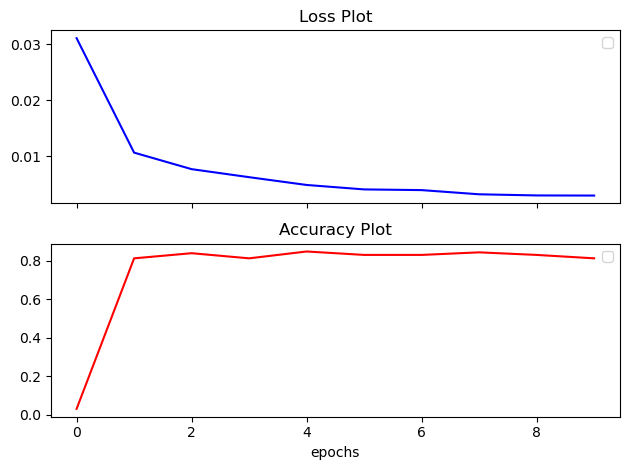

In [15]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax1.plot(losses, color='blue')
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
ax2.plot(accuracies, color='red')
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

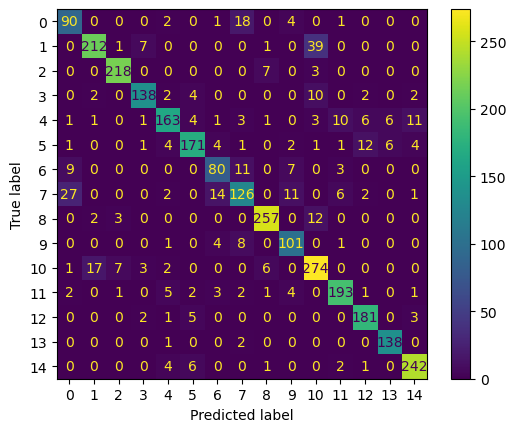

In [16]:
pred_tensor, labels_tensor = get_test_predictions(alex_net, testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

In [17]:
es_model = alexnet(weights='DEFAULT') # early stopping model
es_opt = torch.optim.Adam(es_model.parameters(), lr=0.001)

es_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=15)
es_opt = torch.optim.Adam(es_model.parameters(), lr=0.001)

for param in es_model.parameters():
    param.requires_grad = False

for param in es_model.classifier[6].parameters():
    param.requires_grad = True

print(f"Final accuracy: {get_accuracy(es_model, validloader)}")

c:\Users\goate\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Final accuracy: 0.04888888821005821


## Early Stoping

This loop is a simple early stopping implemetation; it uses GL as a stopping criterion to know if we are "overfitting" model.
At every iteration it checks if the previous model did better than the last one and if so, saves it.

Slow because AlexNet is a large model so to save it requires time.

In [18]:
GL = lambda val_err, opt_err: 100*((val_err/opt_err) - 1) # GL measure based on the cited paper

MAX_EPOCHS = 1000
epoch = 0

alpha = 3

accuracies = []
losses = []
valid_errors = []

SAVE_PATH = 'best_model.pt'

optimal_error = np.inf
validation_error = 0


while(GL(validation_error, optimal_error) < alpha and epoch < MAX_EPOCHS):
	# print(f"Epoch: {epoch : 04d}, Test loss: {one_epoch_loss : .05f}, GL: {GL(validation_error, optimal_error): e}, accuracy: {1 - validation_error: e}", end="\r")
	print(f"Epoch: {epoch : 04d}, GL: {GL(validation_error, optimal_error): e}, accuracy: {get_accuracy(es_model, validloader): e}", end="\r")

	validation_error = 1 - get_accuracy(es_model, validloader)
	accuracies.append(1 - validation_error)
	
	one_epoch_loss = train_one_epoch(es_model, trainloader, es_opt)
	epoch += 1
	
	losses.append(one_epoch_loss)


	if validation_error < optimal_error:
		optimal_error = validation_error
		torch.save({
			"model_state_dict": es_model.state_dict(),
			"optimizer_state_dict": es_opt.state_dict()
		}, SAVE_PATH)
print('\r')
print(f'GL: {GL(validation_error, optimal_error)}')

Epoch:  004, GL:  0.000000e+00, accuracy:  8.400000e-01
GL: 16.1290283203125


In [19]:
# Here we are loading the best early stopping model

es_model = alexnet()
es_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=15)

checkpoint = torch.load(SAVE_PATH)
es_model.load_state_dict(checkpoint["model_state_dict"])

print(f"Final accuracy: {get_accuracy(es_model, validloader)}")

Final accuracy: 0.8399999737739563


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


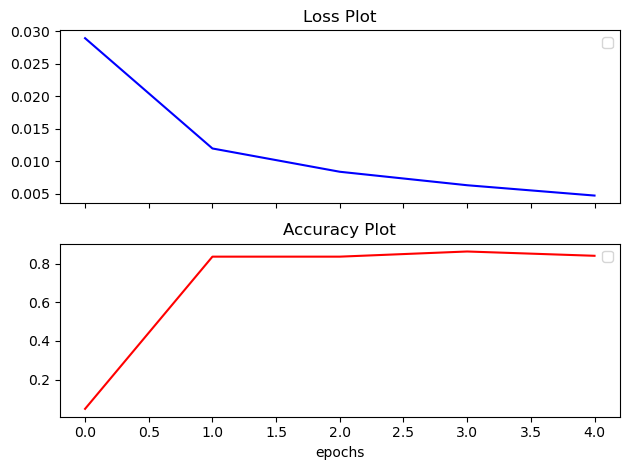

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax1.plot(losses, color='blue')
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
ax2.plot(accuracies, color='red')
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')
plt.tight_layout()

# Show the plot
plt.show()

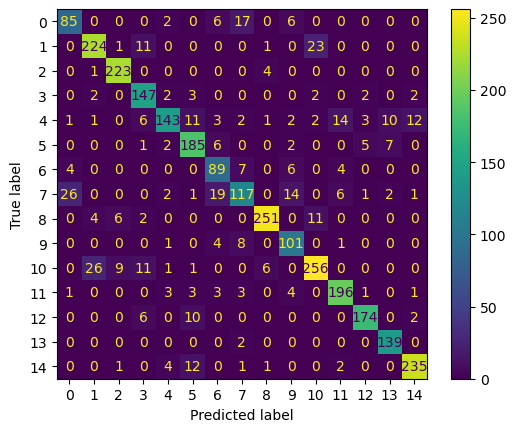

In [21]:
# Here we are calculating the cofusion matrix

pred_tensor, labels_tensor = get_test_predictions(es_model, testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()